In [1]:
import sys; sys.path.insert(0, '..')

import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from database.dataset import *
from mc_candidate_proposal.hough_mc import HoughCalcificationDetection
from feature_extraction.feature_extraction import CandidatesFeatureExtraction
import feature_extraction.haar_features.haar_modules as hm
from general_utils.plots import plot_froc, plot_bootstrap_froc
from metrics.metrics import froc_curve, froc_curve_bootstrap
from mc_candidate_proposal.candidate_utils import balance_candidates
from metrics.metrics_utils import (get_froc_df_of_img, get_froc_df_of_many_imgs_features,
                                   get_tp_fp_fn_center_patch_criteria)

pd.options.mode.chained_assignment = None
cmap = plt.get_cmap("tab10")

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    partitions=['train', 'validation'],
    min_breast_fraction_roi=0.5,
    normalize=None,
    n_jobs=-1,
    use_muscle_mask=True
)

# Settings

In [3]:
CENTER_CROP_PATCH = 7
PATCH_SIZE = 30

hd = HoughCalcificationDetection()

# Feature extractor
haar_params = {
    'skimage': {
        'feature_type': [], 'feature_coord': []
    },
    'ours': {
        'horizontal_feature_types': [(hm.Feature3h3v, 3, 3)],
        'rotated_feature_types': [],
        'horizontal_feature_selection': None,
        'rotated_feature_selection': None,
    },
    'patch_size': 14
}

cfe = CandidatesFeatureExtraction(patch_size=PATCH_SIZE, fos=False, haar_params=haar_params)

# Example of how to train / validate a model with my changes
# (using feature arrays of all candidates)

100%|██████████| 60/60 [01:22<00:00,  1.38s/it]


Auc test: 0.7352520144793193


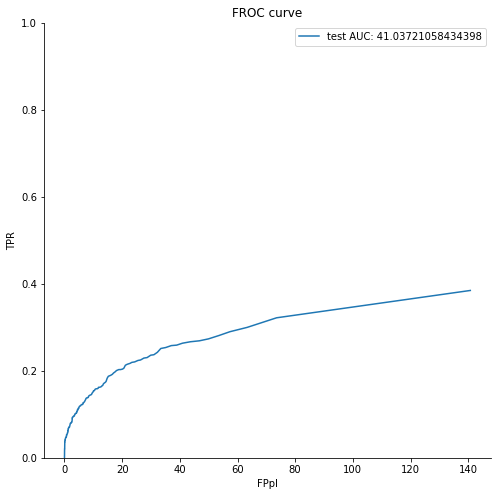

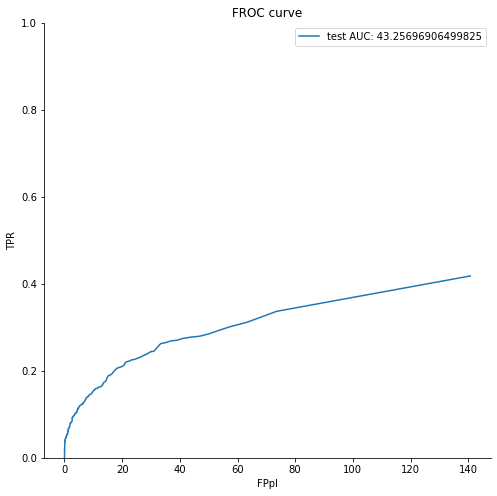

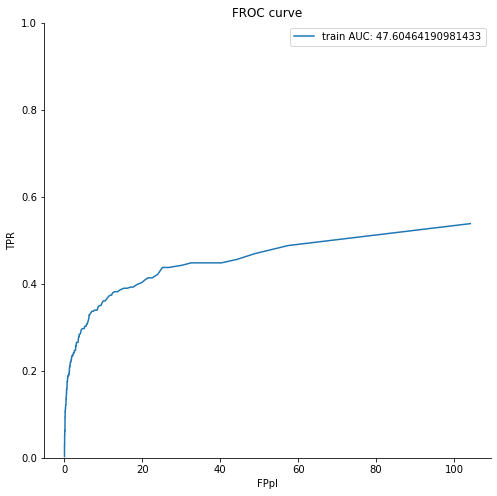

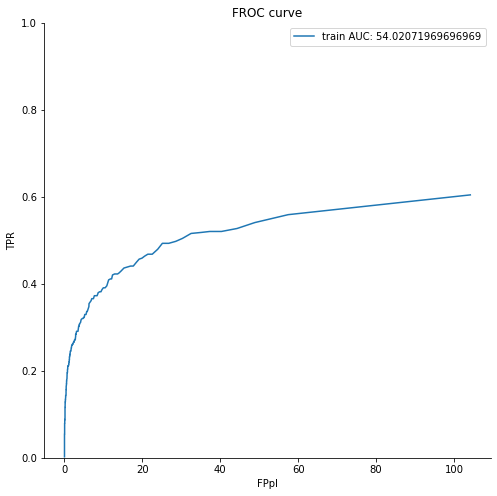

100%|██████████| 30/30 [00:25<00:00,  1.17it/s]


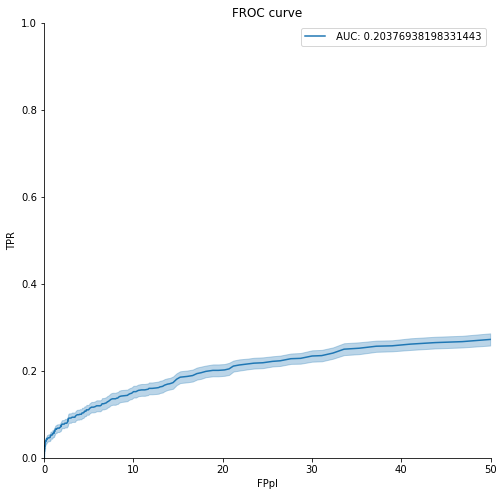

In [4]:
test_img_id = db.df.img_id.unique()[:30] 
fdf = []
fns_df = []
for idx in tqdm(range(60)):
    # Get image to process
    db_sample = db[idx]
    image = db_sample['img']
    image_id = db_sample['img_id']
    image_mask = db_sample['lesion_mask']
    muscle_mask = db_sample['muscle_mask']

    # candidate detection
    candidates = hd.detect(
        image, image_id, load_processed_images=True, hough2=False, muscle_mask=muscle_mask)[0]

    # labeling of candidates:
    tp, fp, fn = get_tp_fp_fn_center_patch_criteria(
        candidates, image_mask, CENTER_CROP_PATCH, PATCH_SIZE)
    candidates = pd.concat([tp, fp], axis=0, ignore_index=True)

    # Balancing the candidates
    candidates = balance_candidates(candidates, fp2tp_sample=10)

    # Extracting features
    labels = np.where(candidates.label.values == 'TP', True, False)
    
    # Avoid extracting features for repeted detections
    X = candidates.drop_duplicates(subset='repeted_idxs')
    X = cfe.extract_features(X.loc[:,['x','y','radius']].values.astype(int), image)

    # Get features dfs
    X = pd.DataFrame(data=X, columns=cfe.feature_names)
    X.index = candidates.drop_duplicates(subset='repeted_idxs').index

    res = X.loc[candidates.repeted_idxs.tolist(),:]
    res['img_id'] = image_id
    res['repeted_idxs'] = candidates.repeted_idxs.tolist()
    res['matching_gt'] = candidates.matching_gt.tolist()
    res['label'] = labels

    # Generate a fn dataframe to compute frocs
    fn['img_id'] = image_id
    fns_df.append(fn)
    fdf.append(res)

data = pd.concat(fdf, ignore_index=True)
fns_df = pd.concat(fns_df, ignore_index=True)

# Divide train and test based on cases (cross validation image wise)
train_df = data[~data.img_id.isin(test_img_id)]
train_fns_df = fns_df[~fns_df.img_id.isin(test_img_id)]
test_df = data[data.img_id.isin(test_img_id)]
test_fns_df = fns_df[fns_df.img_id.isin(test_img_id)]

# Generate features and labels datasets
not_feat_columns = ['patch_coordinates', 'candidate_coordinates', 'label', 'img_id', 'repeted_idxs', 'matching_gt']
train_X = train_df.drop_duplicates(subset=['repeted_idxs'])
train_X = train_X.drop(columns=not_feat_columns)
train_y = (train_df.drop_duplicates(subset=['repeted_idxs']).label).astype(int)
test_X = test_df.drop(columns=not_feat_columns)
test_y = (test_df.label).astype(int)

#Train a random forest classifier
clf = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
clf.fit(train_X, train_y)

# Store the trained models
path = (Path.cwd().parent.parent / 'data')
filename = f'test_roc_clf.sav'
pickle.dump(clf, open(path / filename, 'wb'))

# Predict
test_y_predicted = clf.predict_proba(test_X)[:, 1]
train_y_predicted = clf.predict_proba(train_df.drop(columns=not_feat_columns))[:, 1]

auc_test = roc_auc_score(test_y, test_y_predicted)

print(f'Auc test: {auc_test}')

froc_df = get_froc_df_of_many_imgs_features(
    test_df[['candidate_coordinates', 'label', 'img_id', 'matching_gt', 'repeted_idxs']],
    test_fns_df,
    test_y_predicted
)

froc_df_train = get_froc_df_of_many_imgs_features(
    train_df[['candidate_coordinates', 'label', 'img_id', 'matching_gt', 'repeted_idxs']],
    train_fns_df,
    train_y_predicted
)

sens, avgs_fp_per_image, _ = froc_curve(froc_df)
plot_froc(avgs_fp_per_image, sens, label='test')
sens, avgs_fp_per_image, _ = froc_curve(froc_df, non_max_supression=False)
plot_froc(avgs_fp_per_image, sens, label='test')
sens, avgs_fp_per_image, _ = froc_curve(froc_df_train)
plot_froc(avgs_fp_per_image, sens, label='train')
sens, avgs_fp_per_image, _ = froc_curve(froc_df_train, non_max_supression=False)
plot_froc(avgs_fp_per_image, sens, label='train')

avg_sensitivities, std_sensitivities, avg_avgs_fp_per_image, _, _ = froc_curve_bootstrap(froc_df, n_sets=30, non_max_supression=True)
plot_bootstrap_froc(avg_avgs_fp_per_image, avg_sensitivities, std_sensitivities)

# Example of how to test image by image a model with my changes

100%|██████████| 60/60 [00:51<00:00,  1.15it/s]


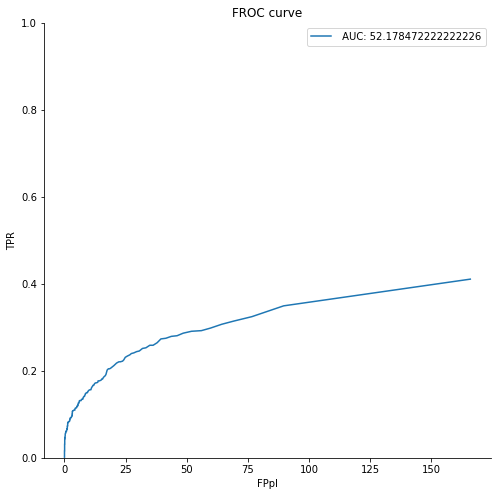

100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


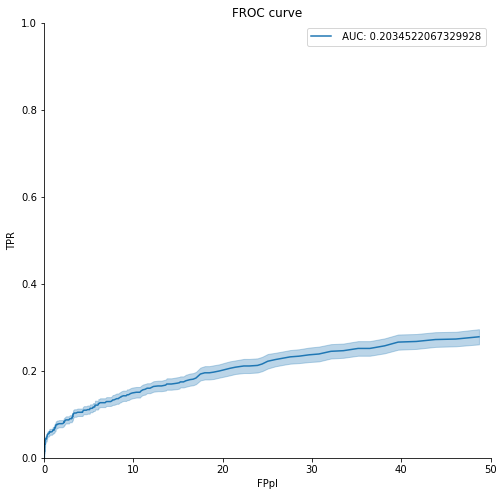

In [5]:
# Save the model to disk
test_img_id = db.df.img_id.unique()[:20]
path = (Path.cwd().parent.parent / 'data')
filename = f'test_roc_clf.sav'
clf = pickle.load(open(path / filename, 'rb'))

froc_dfs = []
for idx in tqdm(range(60)):
    # Get image to process
    db_sample = db[idx]
    image = db_sample['img']
    image_id = db_sample['img_id']
    if image_id not in test_img_id:
        continue
    
    image_mask = db_sample['lesion_mask']
    muscle_mask = db_sample['muscle_mask']

    # candidate detection
    candidates = hd.detect(
        image, image_id, load_processed_images=True, hough2=False, muscle_mask=muscle_mask)[0]

    # labeling of candidates:
    tp, fp, fn = get_tp_fp_fn_center_patch_criteria(
        candidates, image_mask, CENTER_CROP_PATCH, PATCH_SIZE)
    candidates = pd.concat([tp, fp], axis=0, ignore_index=True)

    # Balancing the candidates
    candidates = balance_candidates(candidates, fp2tp_sample=10)

    # Extracting features
    labels = np.where(candidates.label.values == 'TP', True, False)

    # Avoid extracting features for repeted detections
    X = candidates.drop_duplicates(subset='repeted_idxs')
    X = cfe.extract_features(X.loc[:,['x','y','radius']].values.astype(int), image)

    # Get features dfs
    predictions = clf.predict_proba(X[:,:-2])[:, 1]
    X = pd.DataFrame(data=X, columns=cfe.feature_names)
    
    # Restore repeted detections and generate standar dataframe
    froc_df = get_froc_df_of_img(candidates, fn, predictions, image_id)
    froc_dfs.append(froc_df)

froc_df = pd.concat(froc_dfs, ignore_index=True)

sens, avgs_fp_per_image, _ = froc_curve(froc_df)
plot_froc(avgs_fp_per_image, sens)

avg_sensitivities, std_sensitivities, avg_avgs_fp_per_image, _, _ = froc_curve_bootstrap(froc_df, n_sets=30)
plot_bootstrap_froc(avg_avgs_fp_per_image, avg_sensitivities, std_sensitivities)